# Use the 🤗 transformers-native implementation of ColPali

[![Colab](https://img.shields.io/badge/Open_in_Colab-F9AB00?logo=googlecolab&logoColor=fff&style=for-the-badge)](https://colab.research.google.com/github/tonywu71/colpali-cookbooks/blob/main/examples/use_transformers_native_colqwen2.ipynb)
[![GitHub](https://img.shields.io/badge/ColPali_Cookbooks-100000?style=for-the-badge&logo=github&logoColor=white)](https://github.com/tonywu71/colpali-cookbooks)
[![arXiv](https://img.shields.io/badge/arXiv-2407.01449-b31b1b.svg?style=for-the-badge)](https://arxiv.org/abs/2407.01449)
[![Hugging Face](https://img.shields.io/badge/Vidore-FFD21E?style=for-the-badge&logo=huggingface&logoColor=000)](https://huggingface.co/vidore)
<!-- TODO: Update with ColQwen2 Hf thread url when posted -->
<!-- [![X](https://img.shields.io/badge/Thread-%23000000?style=for-the-badge&logo=X&logoColor=white)](https://x.com/tonywu_71/status/1809183824464560138) -->

## Introduction

[ColQwen2](https://huggingface.co/docs/transformers/main/en/model_doc/colqwen2) is a variant of the [ColPali](https://huggingface.co/docs/transformers/main/en/model_doc/colpali) model designed to retrieve documents by analyzing their visual features. Unlike traditional systems that rely heavily on text extraction and OCR, ColQwen2 treats each page as an image. It uses the [Qwen2-VL](./qwen2_vl) backbone to capture not only text, but also the layout, tables, charts, and other visual elements to create detailed multi-vector embeddings that can be used for retrieval by computing pairwise late interaction similarity scores. This offers a more comprehensive understanding of documents and enables more efficient and accurate retrieval.

A key advantage of ColQwen2 is its ability to handle arbitrary image resolutions and aspect ratios, making it particularly suitable for document processing as images are not resized into fixed-size squares.

[![Hugging Face](https://img.shields.io/badge/ColQwen2_hf_transformers_documentation-FFD21E?style=for-the-badge&logo=huggingface&logoColor=000)](https://huggingface.co/docs/transformers/main/en/model_doc/colqwen2)

The following notebook guides you through using the native ColPali model implementation from `transformers` 🤗 for inference, scoring, and interpretability. While there are a few minor differences in the API, all the core functionalities are identical to the original implementation from `colpali-engine==0.3.x`.


### Hardware Requirements

You can run it on Google Colab (using the free-tier T4 GPU) or locally (tested on a M2 Pro Mac). While Colab already has `transformers` pre-installed, it's recommended to update it to the main branch.

In [ ]:
# For Part 1 about inference:
!pip install -q -U huggingface_hub git+https://github.com/huggingface/transformers.git accelerate torch pillow

# For Part 2 about similarity maps:
# Use --no-deps to avoid version conflict with transformers
!pip install -q --no-deps "colpali-engine[interpretability]>=0.3.9,<0.4.0"
!pip install -q -U einops matplotlib seaborn

## Part 1: Run inference with ColPali

### Imports + a few custom utils

In [1]:
from io import BytesIO
from typing import List

import requests
import torch
from IPython.display import display
from PIL import Image
from transformers import ColQwen2ForRetrieval, ColQwen2Processor
from transformers.utils.import_utils import is_flash_attn_2_available


def load_image_from_url(url: str) -> Image.Image:
    """
    Load a PIL image from a valid URL.
    """
    response = requests.get(url)
    return Image.open(BytesIO(response.content))


def scale_image(image: Image.Image, new_height: int = 1024) -> Image.Image:
    """
    Scale an image to a new height while maintaining the aspect ratio.
    """
    # Calculate the scaling factor
    width, height = image.size
    aspect_ratio = width / height
    new_width = int(new_height * aspect_ratio)

    # Resize the image
    scaled_image = image.resize((new_width, new_height))

    return scaled_image

### Load the ColPali model and processor

Click on the following link to open the 🤗 model card for [`vidore/colqwen2-v1.0-hf`](https://huggingface.co/vidore/colqwen2-v1.0-hf).

In [ ]:
model_name = "vidore/colqwen2-v1.0-hf"

model = ColQwen2ForRetrieval.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    attn_implementation="flash_attention_2" if is_flash_attn_2_available() else None,
).eval()

processor = ColQwen2Processor.from_pretrained(model_name)

### Image and query inputs

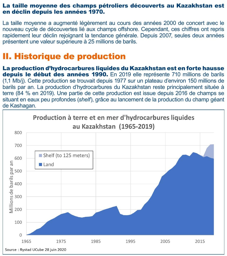

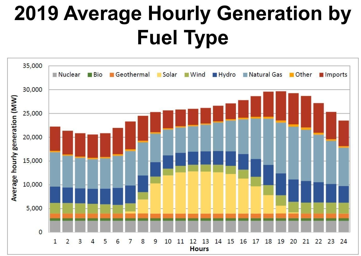

In [3]:
# Load the image and query inputs
urls: List[str] = [
    "https://github.com/tonywu71/colpali-cookbooks/blob/main/examples/data/shift_kazakhstan.jpg?raw=true",
    "https://github.com/tonywu71/colpali-cookbooks/blob/main/examples/data/energy_electricity_generation.jpg?raw=true",
]
images: List[Image.Image] = [load_image_from_url(url) for url in urls]

queries: List[str] = [
    "Quelle partie de la production pétrolière du Kazakhstan provient de champs en mer ?",
    "Which hour of the day had the highest overall electricity generation in 2019?",
]

# Preview the input images
for image in images:
    display(scale_image(image, 256))

### Preprocess and embed the queries and the images

In [21]:
# Preprocess inputs
batch_images = processor(images=images).to(model.device)
batch_queries = processor(text=queries).to(model.device)

# Forward pass
with torch.no_grad():
    image_embeddings = model(**batch_images).embeddings
    query_embeddings = model(**batch_queries).embeddings

### Score the queries against the images

With the notebook's default images and queries, you should obtain a score matrix where the maximum scores are on the diagonal. This means the model has retrieved the correct image for each query.

In [5]:
scores = processor.score_retrieval(query_embeddings, image_embeddings)  # (n_queries, n_images)

scores

tensor([[21.7500,  9.2500],
        [ 9.8125, 22.0000]], dtype=torch.bfloat16)

## Part 2: Generate similarity maps

By superimposing the late interaction similarity heatmap on top of the original image, we can visualize the
most salient image patches with respect to each term of the query, yielding interpretable insights
into ColQwen2's focus zones. We call this a *similarity map* 🗺️.

This section will show you how to generate similarity maps for a given query and image pair. Keep your 👀 peeled!

### Imports + a few more utils!

In [6]:
import pprint
from typing import Tuple

import matplotlib.pyplot as plt
from colpali_engine.interpretability import (
    get_similarity_maps_from_embeddings,
    plot_all_similarity_maps,
    plot_similarity_map,
)
from transformers import BatchFeature, ProcessorMixin
from transformers.models.qwen2_vl.image_processing_qwen2_vl import smart_resize


def get_n_patches(
    processor: ColQwen2Processor,
    image_size: Tuple[int, int],
    patch_size: int,
    spatial_merge_size: int,
) -> Tuple[int, int]:
    height_new, width_new = smart_resize(
        width=image_size[0],
        height=image_size[1],
        factor=patch_size * processor.image_processor.merge_size,
        min_pixels=processor.image_processor.size["shortest_edge"],
        max_pixels=processor.image_processor.size["longest_edge"],
    )

    n_patches_x = width_new // patch_size // spatial_merge_size
    n_patches_y = height_new // patch_size // spatial_merge_size

    return n_patches_x, n_patches_y


def get_image_mask(processor: ProcessorMixin, batch_images: BatchFeature) -> torch.Tensor:
    image_token_id = processor.tokenizer.added_tokens_encoder[processor.image_token]
    return batch_images.input_ids == image_token_id

### Get the per-token similarity maps

In [ ]:
# Get the number of patches and the image mask for each image of the batch
batched_n_patches: List[Tuple[int, int]] = []  # [(n_patches_x, n_patches_y), ...]

for image in images:
    n_patches = get_n_patches(
        processor=processor,
        image_size=image.size,
        patch_size=model.vlm.config.vision_config.patch_size,
        spatial_merge_size=model.vlm.config.vision_config.spatial_merge_size,
    )
    batched_n_patches.append(n_patches)

image_mask = get_image_mask(processor=processor, batch_images=batch_images)

# Batch-compute the similarity maps
batched_similarity_maps = get_similarity_maps_from_embeddings(
    image_embeddings=image_embeddings,
    query_embeddings=query_embeddings,
    n_patches=batched_n_patches,
    image_mask=image_mask,
)

### Show the possible tokens to analyze

In [ ]:
# While all similarity maps are computed, we will only visualize the idx-th one
idx = 0
similarity_maps = batched_similarity_maps[idx]  # (query_length, n_patches_x, n_patches_y)

# Remove the padding tokens and the query augmentation tokens
query_content = processor.decode(batch_queries.input_ids[idx])
query_content = query_content.replace(processor.tokenizer.pad_token, "")
query_content = query_content.replace(processor.query_augmentation_token, "").strip()

# Retokenize the cleaned query
query_tokens = processor.tokenizer.tokenize(query_content)

# Use this cell output to choose a token using its index
pprint.pprint({idx: val for idx, val in enumerate(query_tokens)})

{0: 'Query',
 1: ':',
 2: 'ĠQu',
 3: 'elle',
 4: 'Ġpartie',
 5: 'Ġde',
 6: 'Ġla',
 7: 'Ġproduction',
 8: 'Ġp',
 9: 'Ã©t',
 10: 'ro',
 11: 'li',
 12: 'Ã¨re',
 13: 'Ġdu',
 14: 'ĠKazakhstan',
 15: 'Ġprov',
 16: 'ient',
 17: 'Ġde',
 18: 'Ġchamps',
 19: 'Ġen',
 20: 'Ġmer',
 21: 'Ġ?'}


### Select the query token of interest and visualize the associated similarity map

Selected token: `Ġmer`


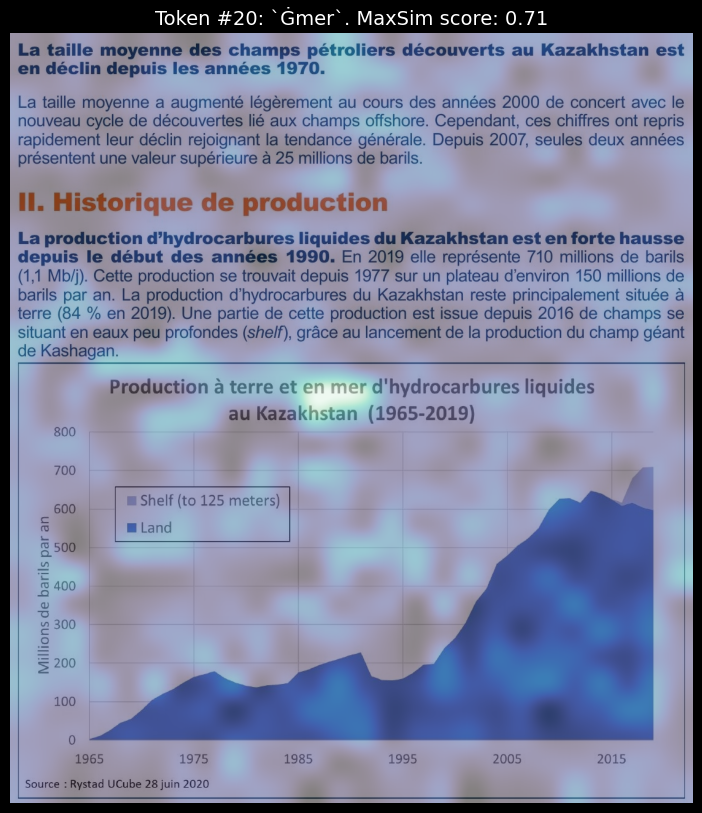

In [ ]:
# Choose a token using its index
token_idx = 20  # e.g. if "20: 'Ġmer',", set to 20 to choose the token 'Ġmer'

print(f"Selected token: `{query_tokens[token_idx]}`")

# Retrieve the similarity map for the chosen token
current_similarity_map = similarity_maps[token_idx]  # (n_patches_x, n_patches_y)

fig, ax = plot_similarity_map(
    image=images[idx],
    similarity_map=current_similarity_map,
    figsize=(8, 8),
    show_colorbar=False,
)

max_sim_score = similarity_maps[token_idx, :, :].max().item()
ax.set_title(f"Token #{token_idx}: `{query_tokens[token_idx]}`. MaxSim score: {max_sim_score:.2f}", fontsize=14)

fig

The brighter the patch, the higher similarity score it has with the selected token. In particular, similarity maps exhibit OCR capabilities and chart understanding of the ColQwen2 model.

### Generate and save similarity maps for all query tokens

You can use the higher-level function `generate_similarity_maps` to generate similarity maps for all query tokens.

In [11]:
plots = plot_all_similarity_maps(
    image=image,
    query_tokens=query_tokens,
    similarity_maps=similarity_maps,
    figsize=(8, 8),
    show_colorbar=False,
    add_title=True,
)

for idx, (fig, ax) in enumerate(plots):
    savepath = f"similarity_map_{idx}.png"
    fig.savefig(savepath, bbox_inches="tight")
    print(f"Similarity map for token `{query_tokens[idx]}` saved at `{savepath}`")

plt.close("all")

Similarity map for token `Query` saved at `similarity_map_0.png`
Similarity map for token `:` saved at `similarity_map_1.png`
Similarity map for token `ĠWhich` saved at `similarity_map_2.png`
Similarity map for token `Ġhour` saved at `similarity_map_3.png`
Similarity map for token `Ġof` saved at `similarity_map_4.png`
Similarity map for token `Ġthe` saved at `similarity_map_5.png`
Similarity map for token `Ġday` saved at `similarity_map_6.png`
Similarity map for token `Ġhad` saved at `similarity_map_7.png`
Similarity map for token `Ġthe` saved at `similarity_map_8.png`
Similarity map for token `Ġhighest` saved at `similarity_map_9.png`
Similarity map for token `Ġoverall` saved at `similarity_map_10.png`
Similarity map for token `Ġelectricity` saved at `similarity_map_11.png`
Similarity map for token `Ġgeneration` saved at `similarity_map_12.png`
Similarity map for token `Ġin` saved at `similarity_map_13.png`
Similarity map for token `Ġ` saved at `similarity_map_14.png`
Similarity map f